## 4.2 从零开始用GAN生成图像
为便于说明GAN的关键环节，这里我们弱化了网络和数据集的复杂度。数据集使用MNIST，网络使用全连接层。后续我们将用一些卷积层的实例来说明。

In [1]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image


# 设备配置
#torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义一些超参数
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 10
batch_size = 100
sample_dir = 'gan_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [2]:
# Image processing
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../data',train=True,transform=trans,download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,batch_size=batch_size, shuffle=True)

## 判别器
获取数据，导入模块的过程基本与VAE的类似，这里不再展开来说。
定义判别器网络结构，这里使用LeakyReLU作为激活函数，经过两个全连接层，输出一个节点，最后经过Sigmoid输出，用于真假二分类。

In [3]:
# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

## 生成器
GAN的生成器与VAE的生成器类似，不同的是GAN的输出为nn.tanh，它可以使数据分布在[-1,1]之间。其输入是潜在空间的向量z，输出维度与真图像的维度相同。

In [4]:
# 构建生成器，这个相当于AVE中的解码器 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.BatchNorm1d(hidden_size, 0.8),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size, 0.8),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

## 定义损失函数，优化器等

In [5]:
# 把判别器和生成器迁移到GPU上
D = D.to(device)
G = G.to(device)

# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

#Clamp函数x限制在区间[min, max]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 开始训练
total_step = len(data_loader)


## 训练模型
把判别器与生成器组合成一个完整模型，并对该模型进行训练。

In [6]:
for epoch in range(num_epochs):
    D_loss_list, G_loss_list = [], []
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs        
     
        # 得到判别器总的损失函数
        d_loss = d_loss_real + d_loss_fake
        D_loss_list.append(d_loss.item())
        
        # 对生成器、判别器的梯度清零        
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        #对判别器的权重进行截取
        #for p in D.parameters():    
        #    p.detach().clamp_(-0.01, 0.01)    
        # Train the generator every n_critic iterations
        #if i % 5 == 0:
        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #

        # 定义生成器对假图片的损失函数，这里我们要求
        #判别器生成的图片越来越像真图片，故损失函数中
        #的标签改为真图片的标签，即希望生成的假图片，
        #越来越靠近真图片
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        
        g_loss = criterion(outputs, real_labels)
        G_loss_list.append(g_loss.item())
        # 对生成器、判别器的梯度清零
        #进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # 保存真图片
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 保存假图片
    if (epoch+1) %10==0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/10], Step [200/600], d_loss: 0.1594, g_loss: 2.8785, D(x): 0.98, D(G(z)): 0.11
Epoch [0/10], Step [400/600], d_loss: 0.1161, g_loss: 2.6692, D(x): 0.99, D(G(z)): 0.09
Epoch [0/10], Step [600/600], d_loss: 0.0464, g_loss: 4.5991, D(x): 1.00, D(G(z)): 0.04
Epoch [1/10], Step [200/600], d_loss: 0.0492, g_loss: 6.0920, D(x): 0.96, D(G(z)): 0.01
Epoch [1/10], Step [400/600], d_loss: 0.2878, g_loss: 5.1483, D(x): 0.92, D(G(z)): 0.08
Epoch [1/10], Step [600/600], d_loss: 0.0943, g_loss: 6.5044, D(x): 0.96, D(G(z)): 0.04
Epoch [2/10], Step [200/600], d_loss: 0.3154, g_loss: 3.6869, D(x): 0.85, D(G(z)): 0.06
Epoch [2/10], Step [400/600], d_loss: 0.4054, g_loss: 5.9749, D(x): 0.92, D(G(z)): 0.10
Epoch [2/10], Step [600/600], d_loss: 0.9466, g_loss: 3.4763, D(x): 0.79, D(G(z)): 0.29
Epoch [3/10], Step [200/600], d_loss: 0.3893, g_loss: 3.2742, D(x): 0.91, D(G(z)): 0.15
Epoch [3/10], Step [400/600], d_loss: 0.3213, g_loss: 3.3615, D(x): 0.91, D(G(z)): 0.13
Epoch [3/10], Step [600/600], d_

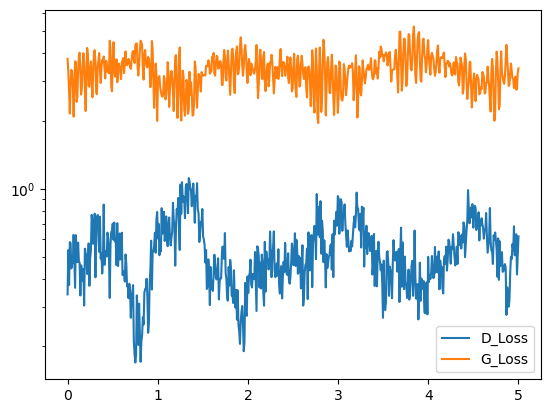

In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

x_axis = np.linspace(0, 5, len(D_loss_list), endpoint=True)
plt.semilogy(x_axis, D_loss_list, label='D_Loss')
plt.semilogy(x_axis, G_loss_list, label='G_Loss')
plt.legend(loc='best')

## 可视化结果
可视化每次由生成器得到的假图像，即潜在向量z通过生成器得到的图像。

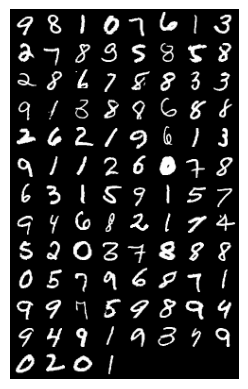

In [8]:
reconsPath = './gan_samples/real_images.png'
Image = imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

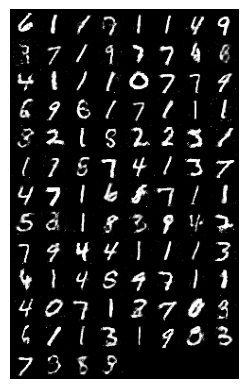

In [9]:
reconsPath = './gan_samples/fake_images-200.png'
Image = imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()